# This is the part of the code, where we train The Cannon

In [1]:
# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic Tools
import numpy as np
import pickle
from astropy.table import Table
from astropy.io import fits
import corner
import matplotlib.pyplot as plt

# The Cannon
import thecannon as tc # see https://github.com/andycasey/AnniesLasso for more details

What do we have to do for the training?
Let's follow the description from https://annieslasso.readthedocs.io/en/latest/guide.html

In [2]:
# Let's load the matrices with fluxes and ivar
flux_ivar_file = open('training_sets/solar_twin_training_set_16xfe_snr50_flux_ivar.pickle','rb')
training_set_flux,training_set_ivar = pickle.load(flux_ivar_file)
flux_ivar_file.close()
wavelength_file = open('training_sets/solar_twin_training_set_16xfe_snr50_wavelength.pickle','rb')
wavelength_array = pickle.load(wavelength_file)
wavelength_file.close()

In [3]:
def apply_mask_censoring(wavelength_array, line_width=0.5):
    # Let's load the mask / censor matrix
    galah_dr3_lines = dict()
    galah_dr3_lines['Li'] = [6707.7635]
    galah_dr3_lines['C']  = [6587.6100]
    galah_dr3_lines['O']  = [7771.9440,7774.1660,7775.3880]
    galah_dr3_lines['Na'] = [4751.8218,5682.6333,5688.2050]
    galah_dr3_lines['Mg'] = [4730.0286,5711.0880,7691.5500,7722.5930,7759.2980]
    galah_dr3_lines['Al'] = [6696.0230,6698.6730,7835.3090,7836.1340]
    galah_dr3_lines['Si'] = [5645.6128,5665.5545,5684.4840,5690.4250,5701.1040,5772.1460,5793.0726,6583.7074,6721.8481,6741.6280,7680.2660,7688.3960,7760.6280,7799.1797,7842.9784]
    galah_dr3_lines['K']  = [5801.7490,7698.9643]
    galah_dr3_lines['Ca'] = [5857.4510,5867.5620,6471.6620,6493.7810,6499.6500,6508.8496]
    galah_dr3_lines['Sc'] = [4743.8300,4753.1610,5671.8163,5686.8386,5724.1070,5657.8960,5658.3610,5667.1490,5669.0420,5684.2020,6604.6010]
    galah_dr3_lines['Ti'] = [4722.6059,4731.1644,4733.4213,4742.1061,4742.7892,4747.6737,4758.1178,4759.2697,4778.2547,4781.7106,4797.9757,4801.9016,4805.4144,4820.4094,4848.4770,4856.0103,4870.1246,4885.0794,5689.4600,5716.4500,5720.4359,5739.4690,5823.6854,5866.4513,6554.2230,6556.0618,6599.1080,6689.2570,6716.6660,6743.1872,6745.5441,7852.6770,4719.5109,4762.7780,4764.5247,4798.5313,4849.1678,4865.6104,4874.0094]
    galah_dr3_lines['Cr'] = [4718.4190,4745.3070,4775.1300,4789.3350,4801.0247,4885.9520,5702.3060,5712.7710,5719.8150,5781.1670,5787.0210,5787.9190,5838.6690,5844.5950,6630.0100,4824.1270,4836.2290,4848.2349]
    galah_dr3_lines['Mn'] = [4739.0900,4754.0301,4761.5060,4765.8525,4766.4145,4783.4320]
    galah_dr3_lines['Ni'] = [4740.1590,4756.5100,4762.6266,4786.2812,4814.5910,4831.1690,4845.3220,4866.2620,4873.4380,4874.7880,4886.7050,5748.3507,5749.2990,5754.6556,5846.9935,6482.7983,6532.8730,6586.3098,6643.6303,7714.3078,7727.6094,7748.8843,7788.9299,7797.5798,7826.7590]
    galah_dr3_lines['Cu'] = [5700.2326,5782.1554]
    galah_dr3_lines['Zn'] = [4722.1530,4810.5280]
    galah_dr3_lines['Y']  = [4819.6383,4854.8611,4883.6821,5662.9241,5728.8865]
    galah_dr3_lines['Ba'] = [5853.6680,6496.8970]

    mask_matrix = Table()
    # Let's start by setting masks=1 for the stellar parameters
    for label in ['teff','logg','fe_h','vbroad']:
        mask_matrix[label] = np.ones(len(wavelength_array),dtype=bool)
    # Now let's loop through the abundances
    for label in galah_dr3_lines.keys():
        censor_array = []
        for line in galah_dr3_lines[label]:
            censor_array.append([line-0.5*line_width,line+0.5*line_width])
        mask_matrix[label+'_fe'] = tc.censoring.create_mask(dispersion=wavelength_array,censored_regions=censor_array)

    # Now let's mask some problematic pixels:
    #exclude_regions = [[6562.31,6562.96],[6653.896, 6654.09]]
    #exclude_mask = []
    #for exclude_region in exclude_regions:
    #    exclude_mask.append(np.where((wavelength_array>=exclude_region[0]) & (wavelength_array<=exclude_region[1]))[0])
    #exclude_mask = np.concatenate((exclude_mask))
    #print(wavelength_array[exclude_mask])
    #for label in mask_matrix.keys():
    #    mask_matrix[label][exclude_mask] = False
        
    return(mask_matrix)

mask_matrix = apply_mask_censoring(wavelength_array)

In [4]:
# Let's load the training set and labels
training_set = Table.read('training_sets/solar_twin_training_set_16xfe_snr50_with_spectra.fits')
labels = np.loadtxt('training_sets/solar_twin_training_set_16xfe_snr50_labels',dtype=str)
labels = tuple(labels)

# There are additional information saved in the training set.
# hereafter, we only need the actual training set labels
training_set_labels = Table()
for label in labels:
    training_set_labels[label] = training_set[label]

In [5]:
# We have to revert this once this is working!
# The first test was done with 3 labels and 50 stars for all pixels.
# labels = ('teff','logg','fe_h'
# nr_stars = 50
# max_pixel = -1
# Turns out, that there is a normalisation issue in the spectra for CCD4 - so let's ignore that CCD for now

# The second test was done with 5 labels and 50 stars and only use CCD1-3, that is up to pixel 11842
# The main reason here was to make sure that the mask/censor function is implemented correctly
# labels = ('teff','logg','fe_h','Na_fe','Mg_fe')
# nr_stars = 50
# max_pixel = 11842
# Turns out the mask/censor is implemented correctly. Some fine-tuning of line-width may be useful

# Now let's move to 17 labels (neglect O and K mainly from CCD4) and 500 stars for CCD1-3
# labels = ('teff','logg','fe_h','Na_fe','Mg_fe','Al_fe','Si_fe','Ca_fe','Sc_fe','Ti_fe','Cr_fe','Mn_fe','Ni_fe','Cu_fe','Zn_fe','Y_fe','Ba_fe')
# nr_stars = 500
# max_pixel = 11842

# Now let's move to 17 labels (neglect O and K mainly from CCD4) and all stars for CCD1-3
labels = ('teff','logg','fe_h','Na_fe','Mg_fe','Al_fe','Si_fe','Ca_fe','Sc_fe','Ti_fe','Cr_fe','Mn_fe','Ni_fe','Cu_fe','Zn_fe','Y_fe','Ba_fe')
nr_stars = np.shape(training_set)[0]
max_pixel = 11842

training_set_labels = Table()
for label in labels:
    training_set_labels[label] = training_set[label]
training_set_labels = training_set_labels[:nr_stars]
training_set_labels = training_set_labels[:nr_stars]
training_set_flux = training_set_flux[:nr_stars,:max_pixel]
training_set_ivar = training_set_ivar[:nr_stars,:max_pixel]
mask_matrix = mask_matrix[:max_pixel]
wavelength_array = wavelength_array[:max_pixel]

In [6]:
# Setup the basic model
model = tc.CannonModel(
    training_set_labels, training_set_flux, training_set_ivar,
    vectorizer=tc.vectorizer.PolynomialVectorizer(labels, 2),dispersion=wavelength_array)

# Implement masks/censors
for label_index, label in enumerate(labels):
    if label not in ['teff','logg','fe_h','vbroad']: # for these labels we use all pixels
        model.censors[label] = mask_matrix[label]

applying sensoring for Na_fe
applying sensoring for Mg_fe
applying sensoring for Al_fe
applying sensoring for Si_fe
applying sensoring for Ca_fe
applying sensoring for Sc_fe
applying sensoring for Ti_fe
applying sensoring for Cr_fe
applying sensoring for Mn_fe
applying sensoring for Ni_fe
applying sensoring for Cu_fe
applying sensoring for Zn_fe
applying sensoring for Y_fe
applying sensoring for Ba_fe


In [ ]:
# This is where the magic happens! We train the Cannon!
theta, s2, metadata = model.train(threads=1)

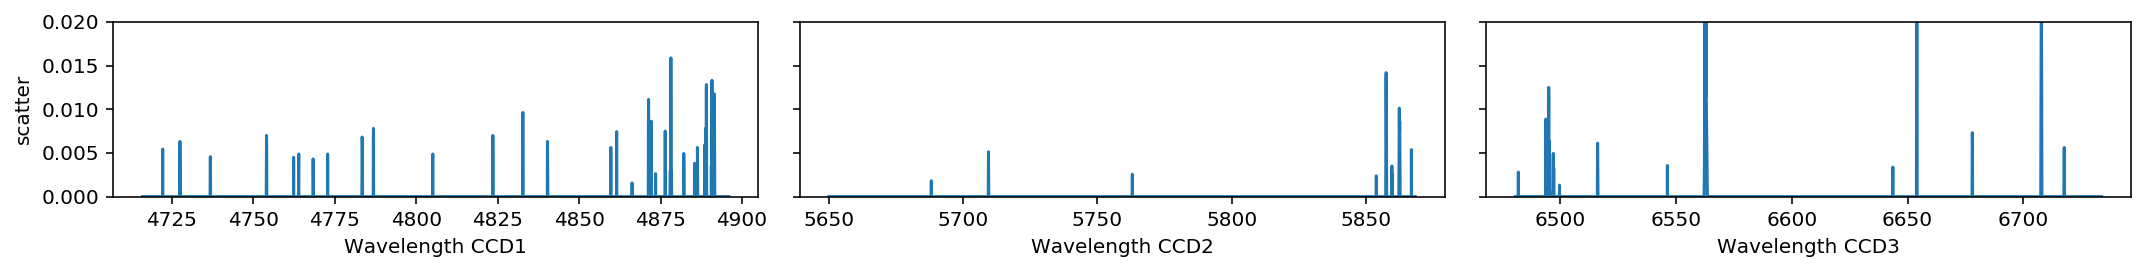

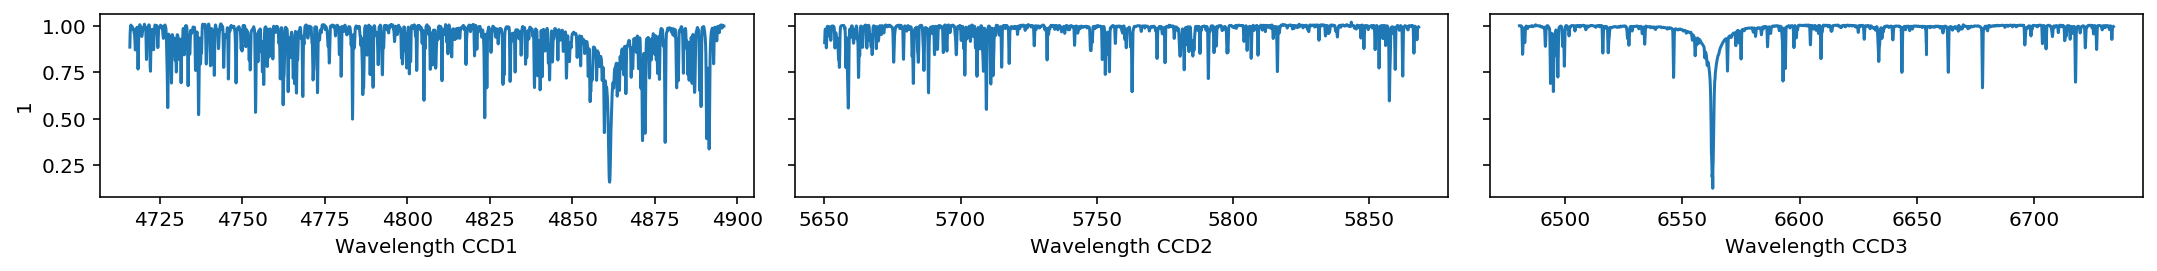

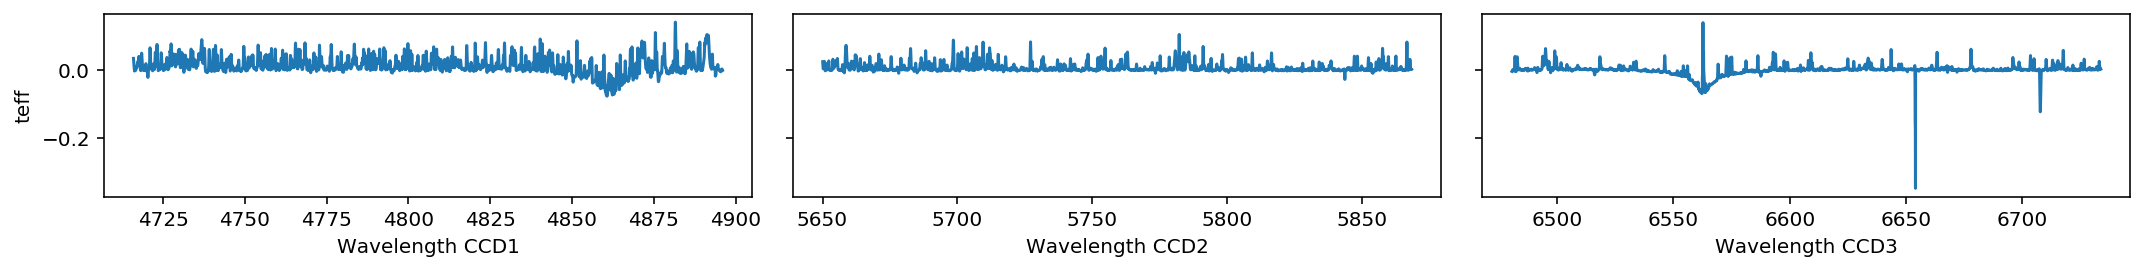

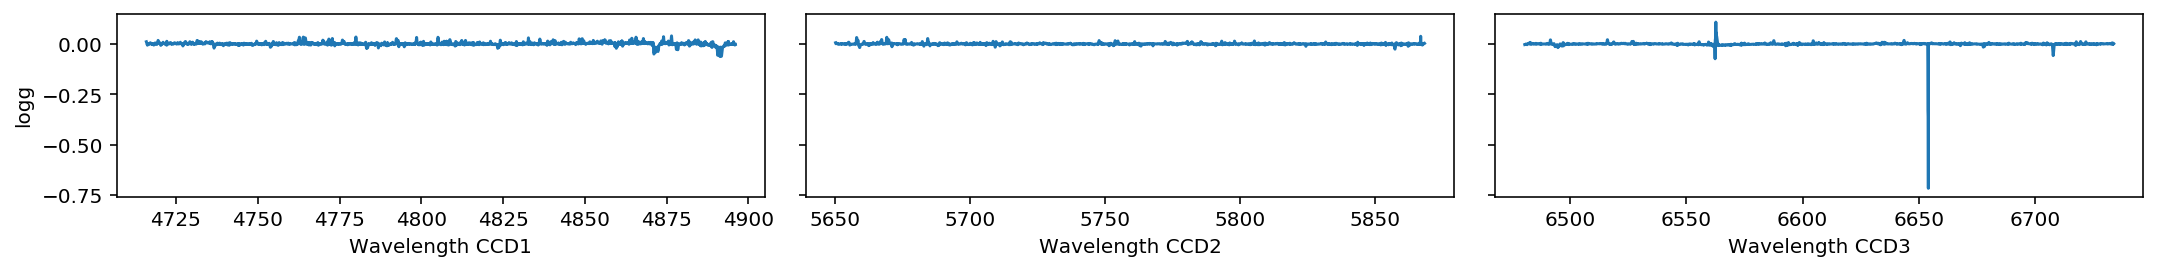

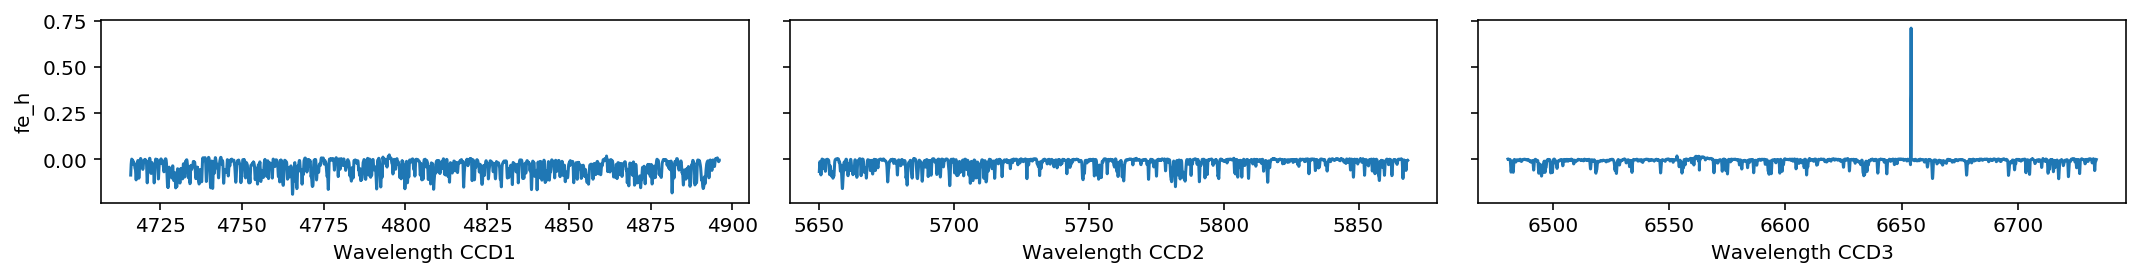

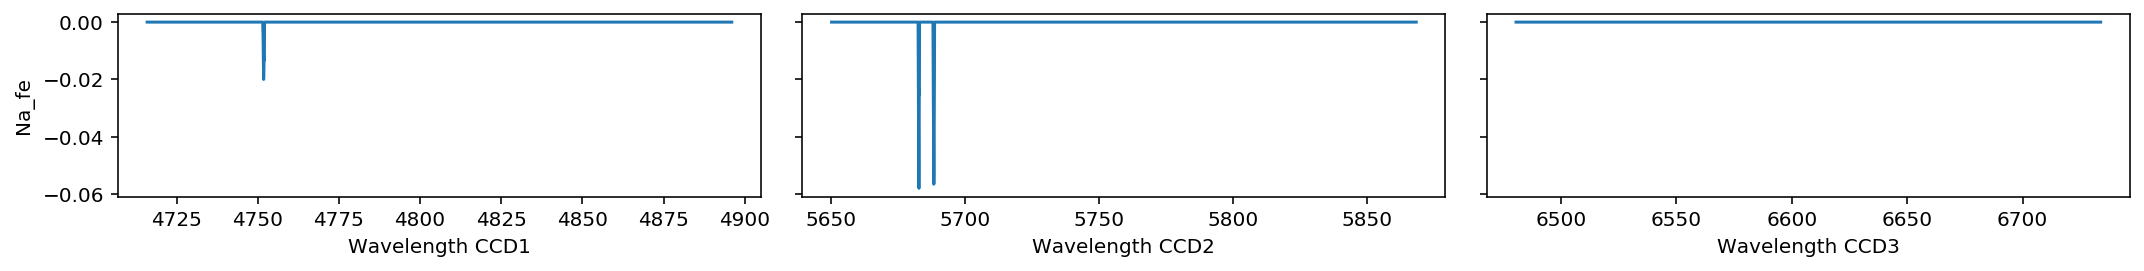

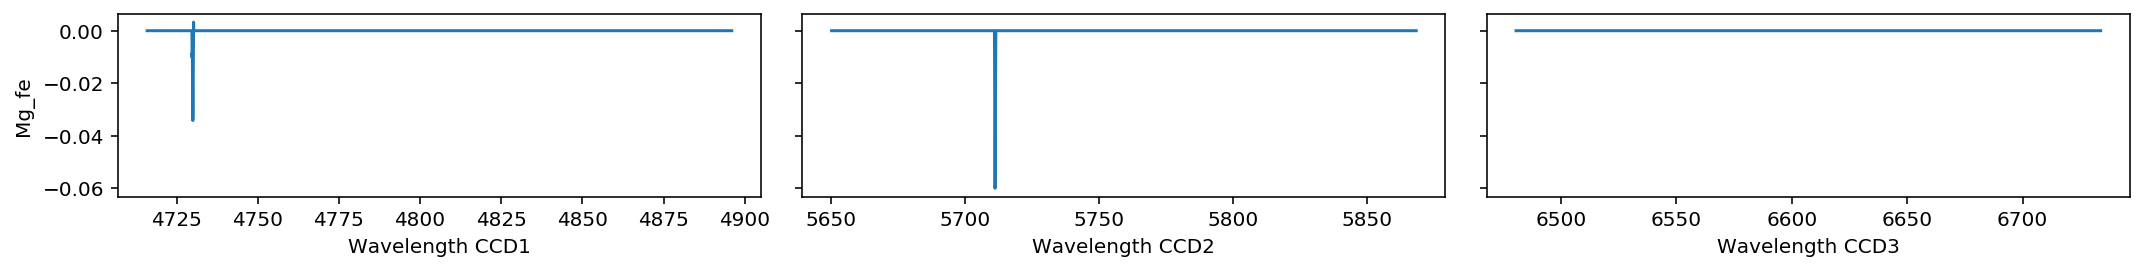

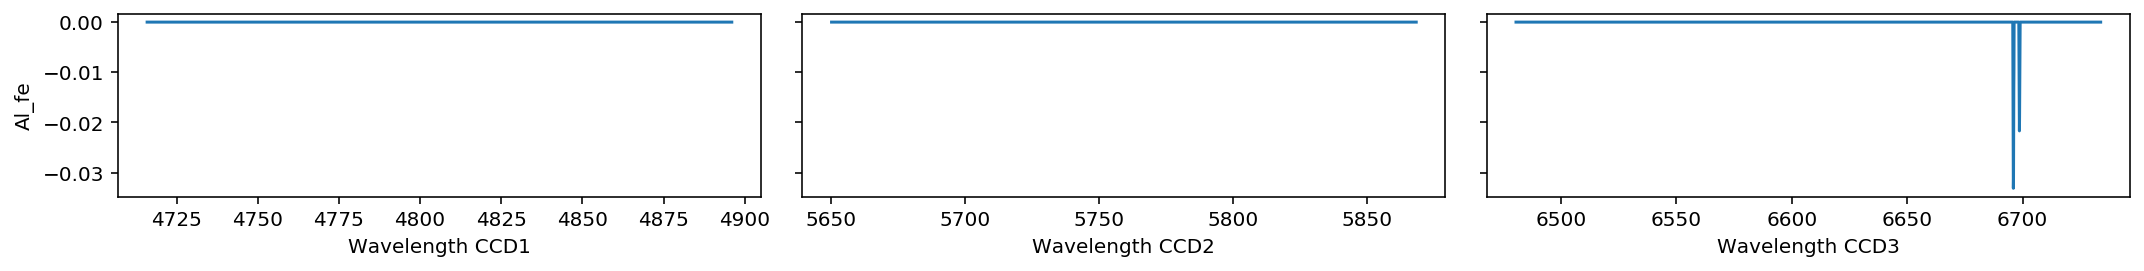

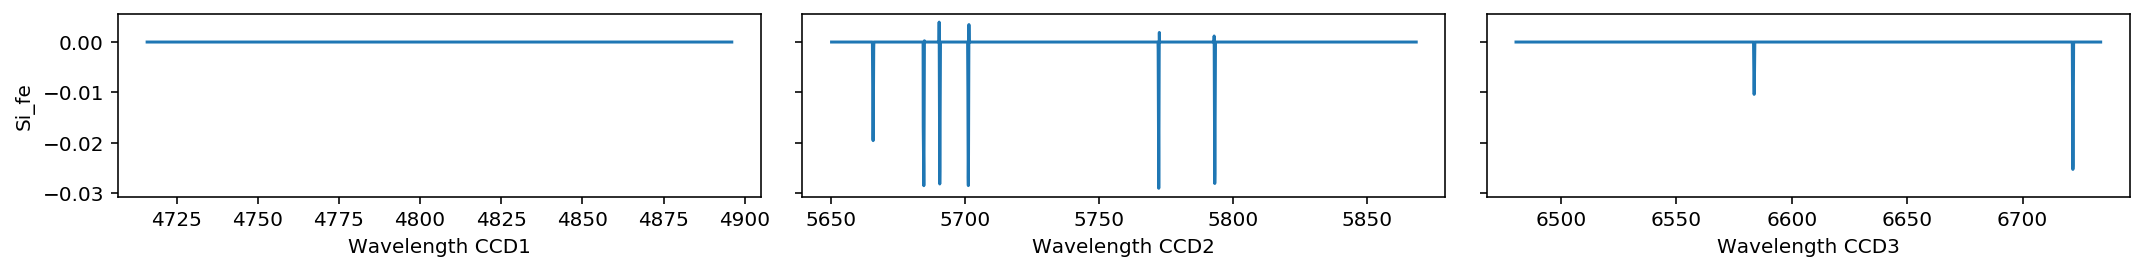

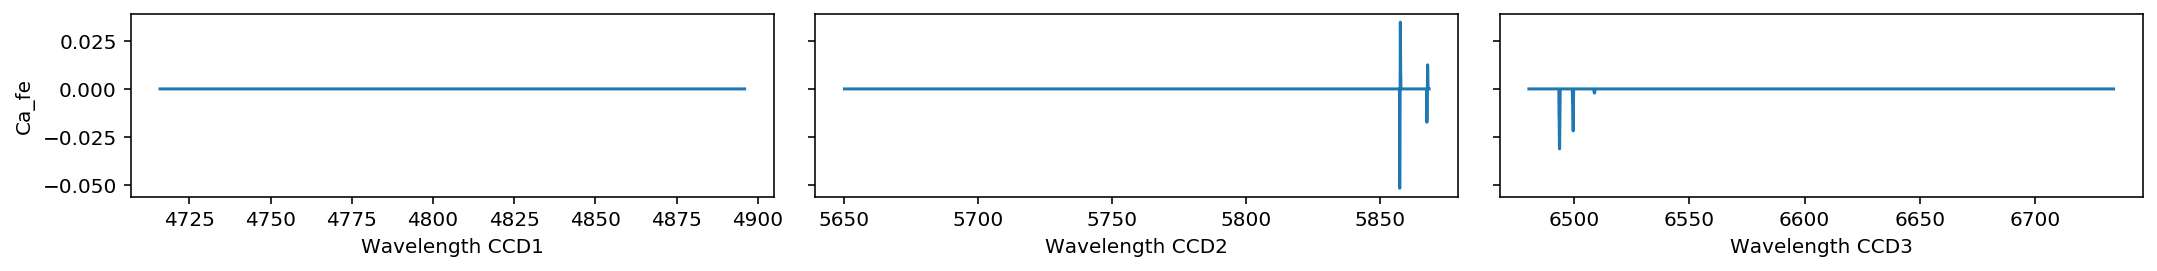

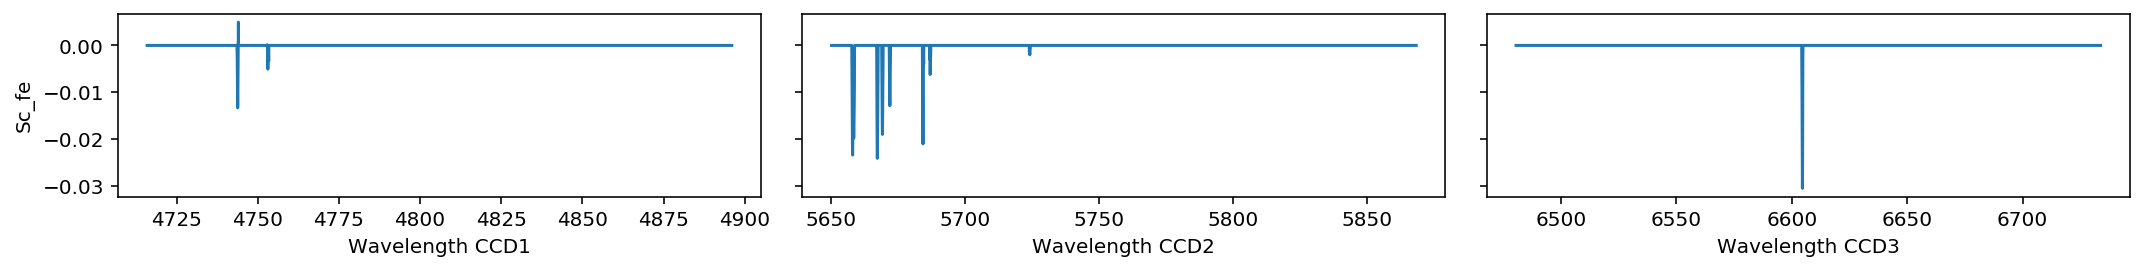

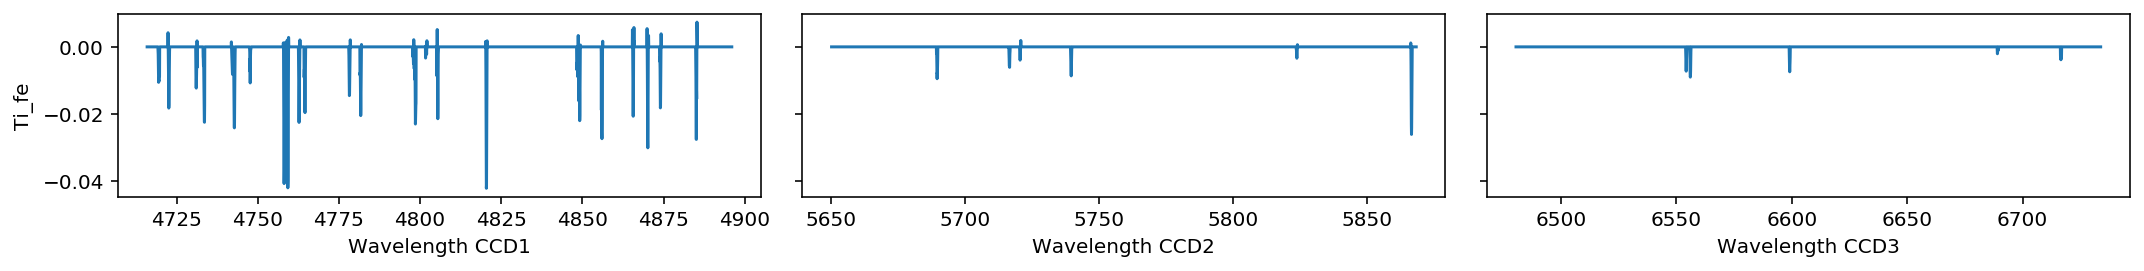

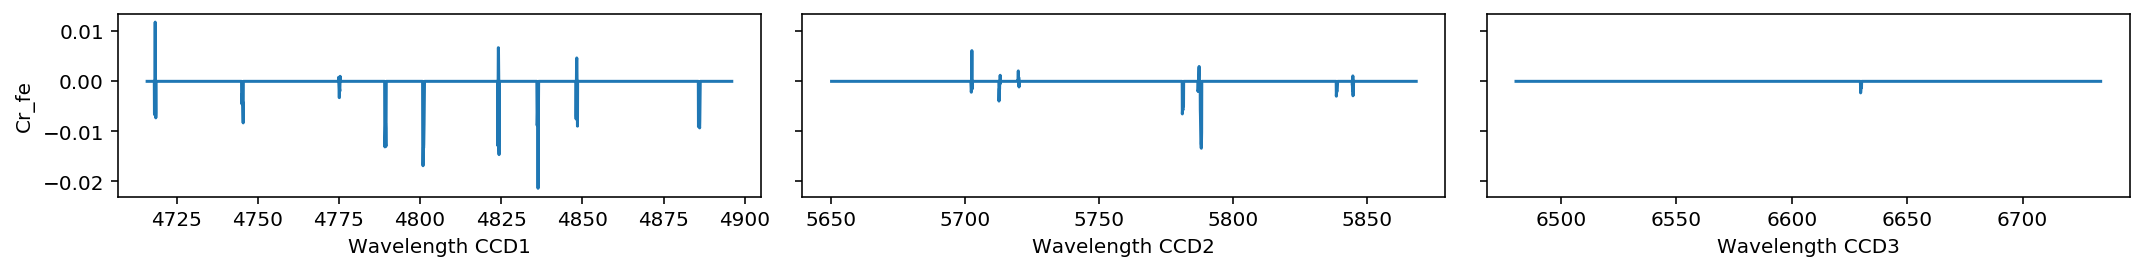

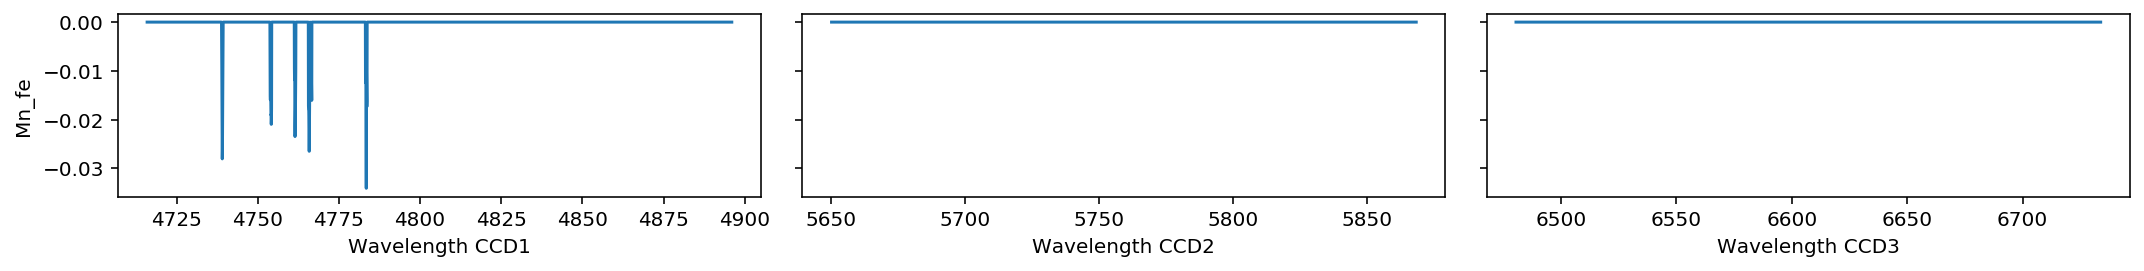

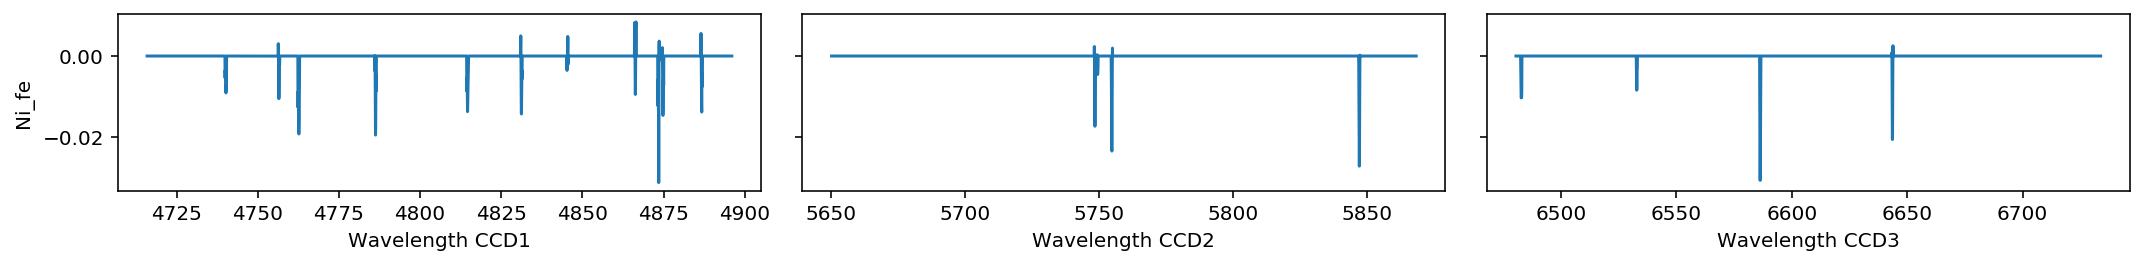

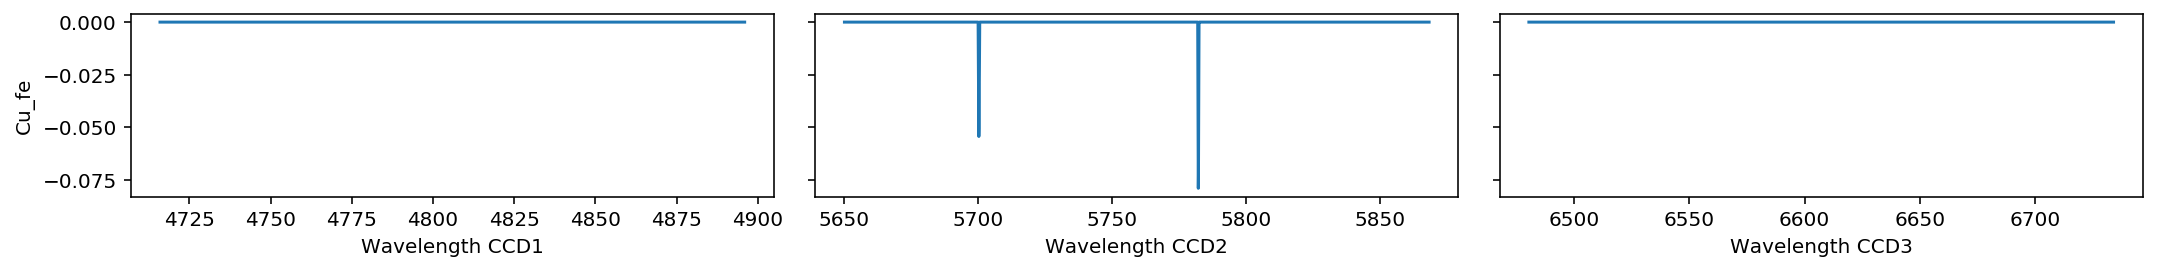

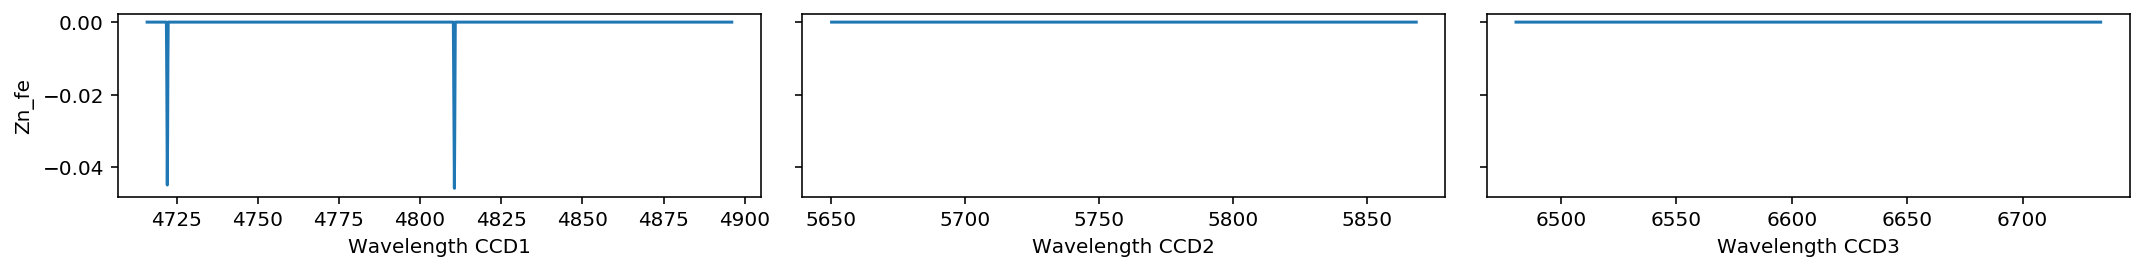

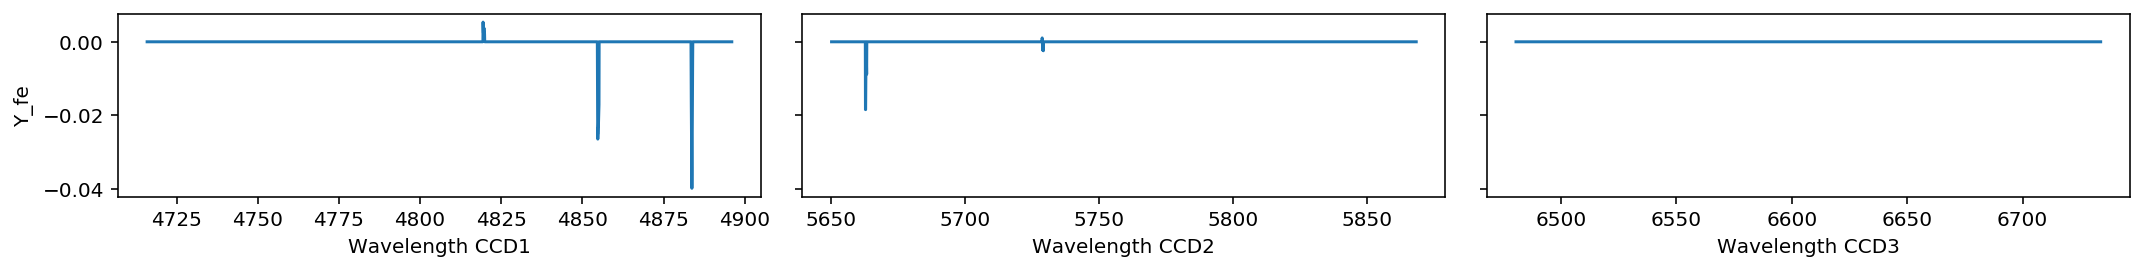

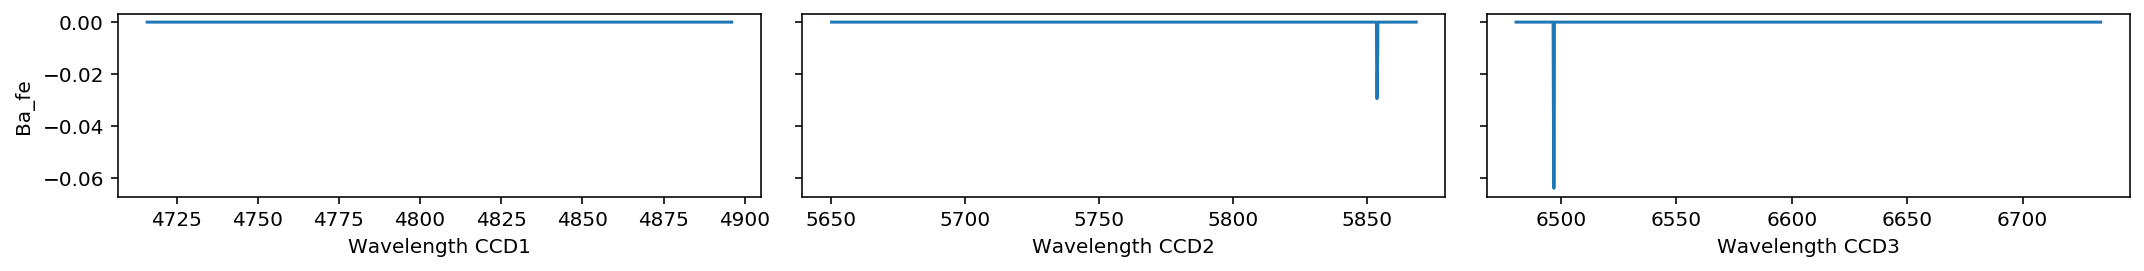

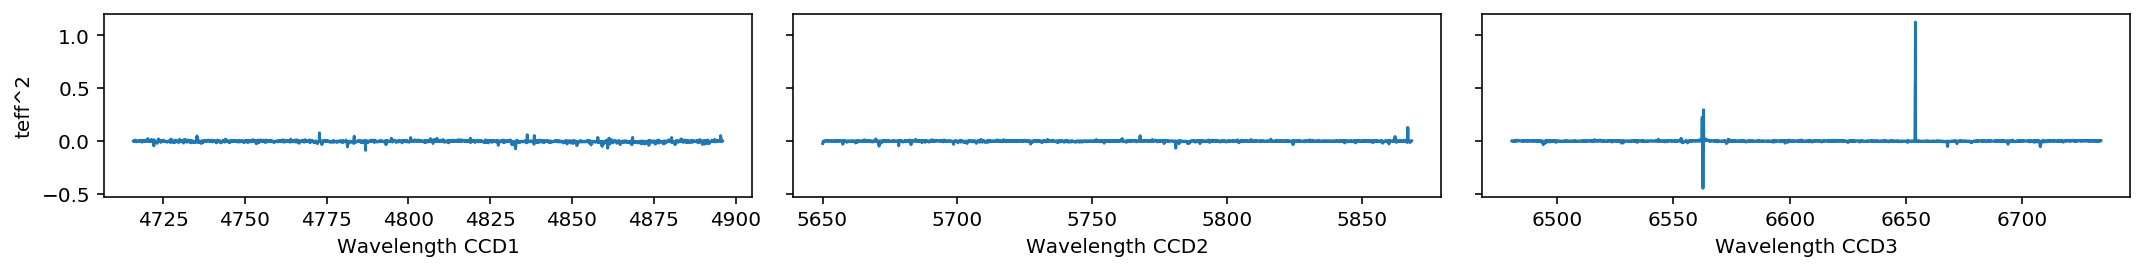

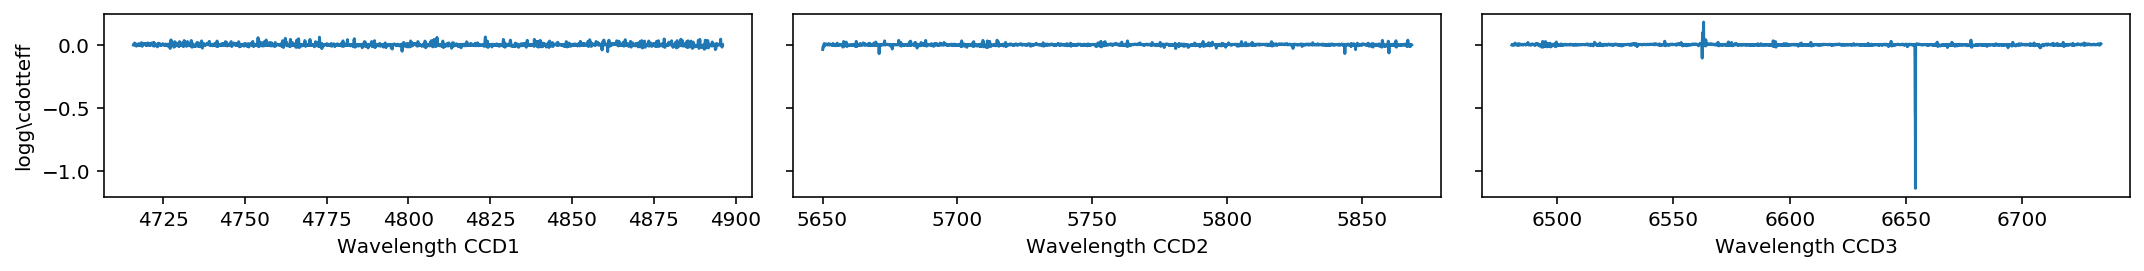

In [14]:
# Now let's plot some of the coefficients to get an idea, which pixels the model considers interesting.
def plot_coefficients(model, index, ccds=[1,2,3,4]):
    
    # let's have an option to plot the scatter with a negative index
    if index == -1:
        ylabel = 'scatter'
    else:
        ylabel = model.vectorizer.get_human_readable_label_term(index,
                label_names = model.vectorizer.label_names, mul='\cdot', pow='^')
        
    f, gs = plt.subplots(1,len(ccds),figsize=(15,2),sharey=True)
    
    for ccd in ccds:
        ax=gs[ccd-1]
        in_wavelength_range = (wavelength_array >= (3+ccd)*1000) & (wavelength_array <= (4+ccd)*1000)
        if index == -1:
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.s2[in_wavelength_range]**0.5
            )
            ax.set_ylim(0,0.02)
        else:
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.theta[in_wavelength_range,index]
            )
        ax.set_xlabel('Wavelength CCD'+str(ccd))
        if ccd==1:
            ax.set_ylabel(ylabel)
    plt.tight_layout()

for index in range(-1,20):
    plot_coefficients(model, index, ccds=[1,2,3])

In [11]:
test_labels, cov, metadata = model.test(training_set_flux, training_set_ivar)

2021-09-02 22:32:20,145 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2021-09-02 22:32:20,148 [INFO] Running test step on 5144 spectra


[====================================================================================================] 100% (1737s)                              


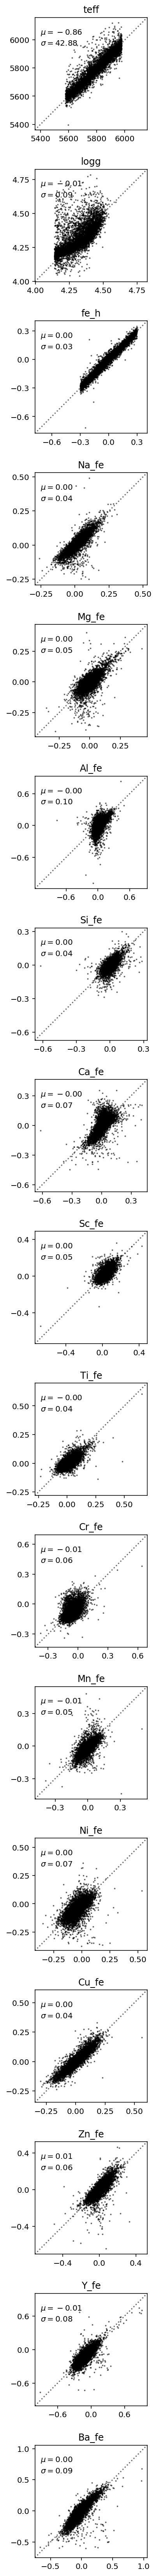

In [12]:
fig_comparison = tc.plot.one_to_one(model, test_labels)

In [13]:
model.write("models/solar_twin_training_set_16xfe_snr50_5144spec_17labels_11842pixels.model",overwrite=True)
#model = tc.CannonModel.read("models/solar_twin_training_set_16xfe_snr50_5144spec_17labels_11842pixels.model")

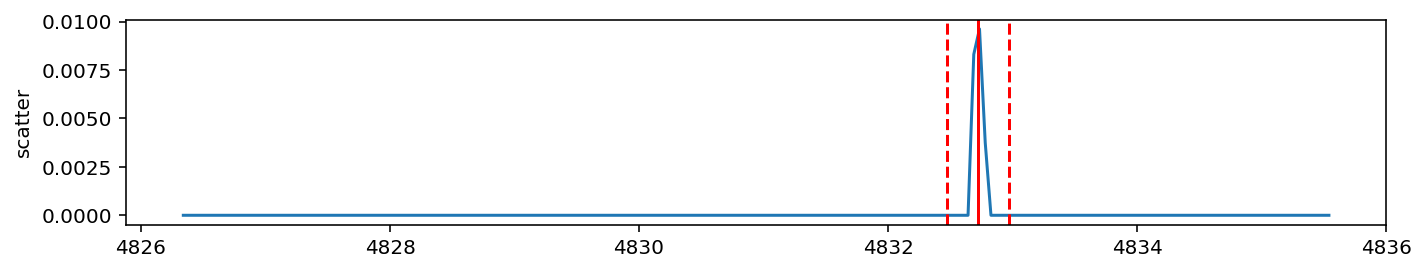

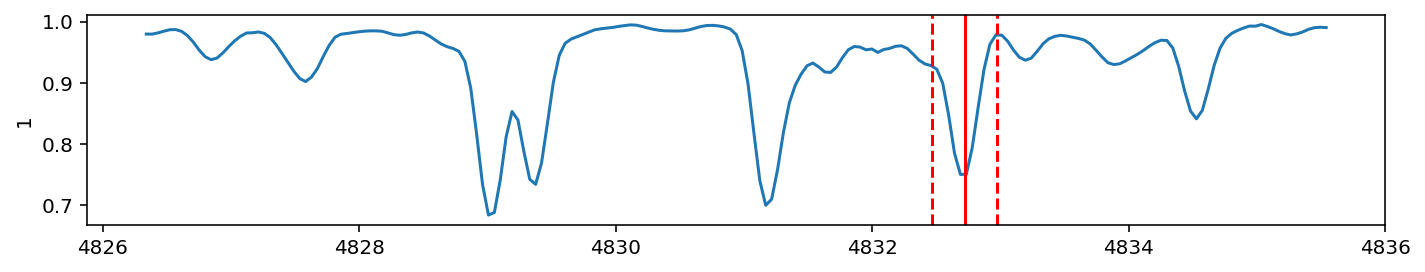

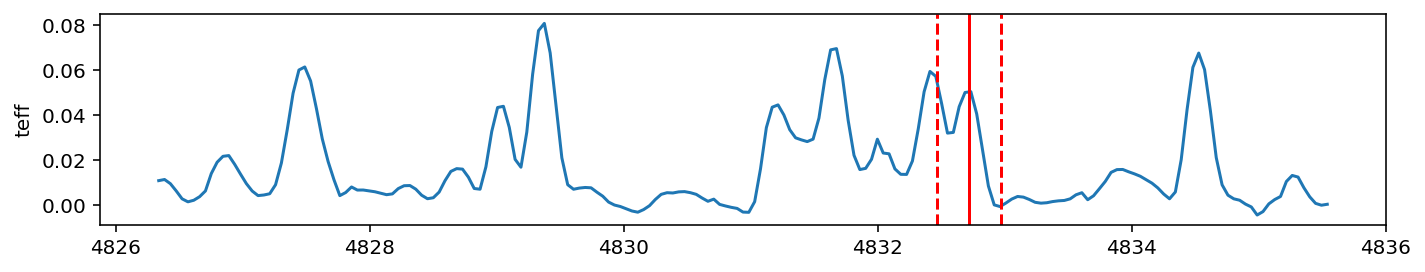

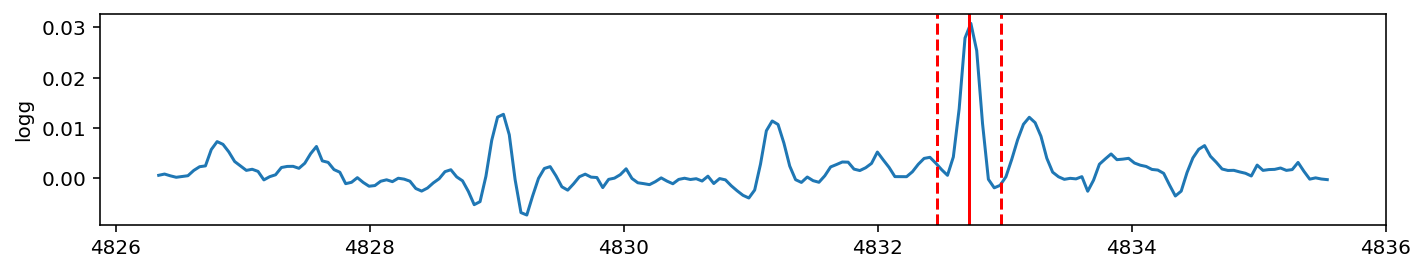

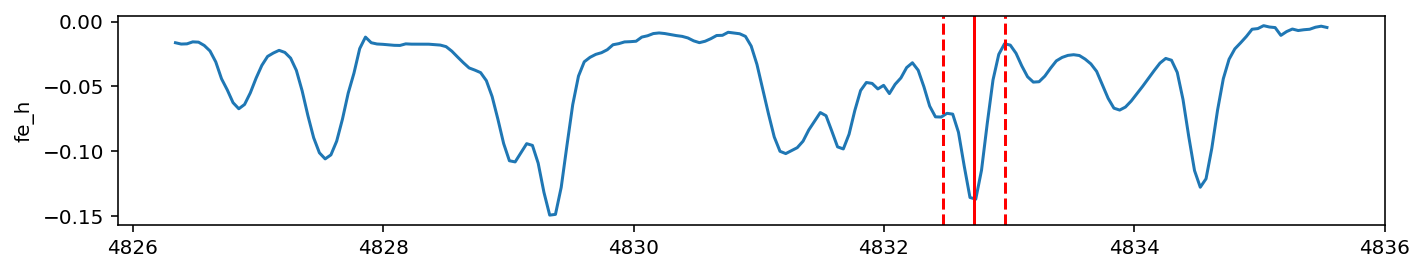

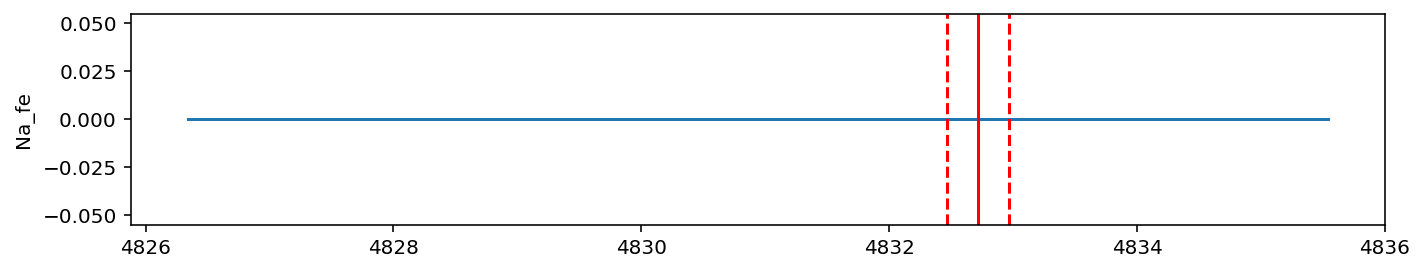

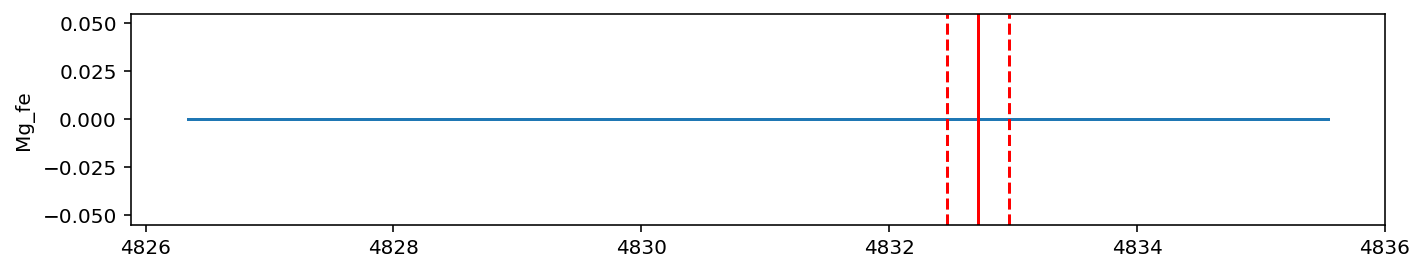

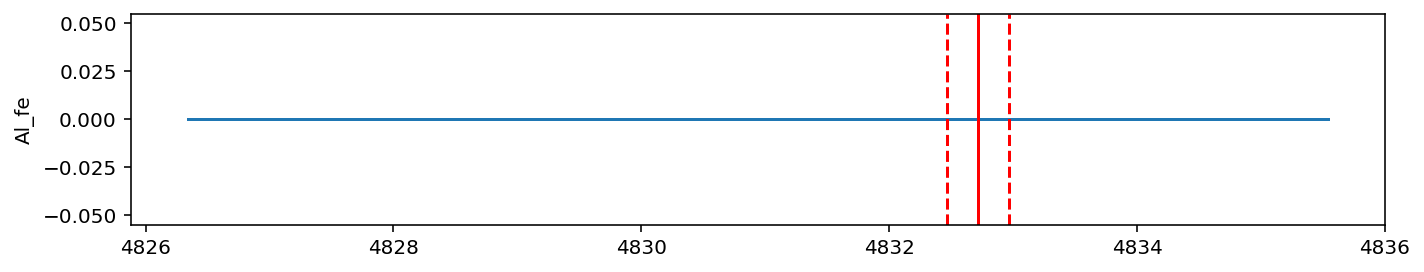

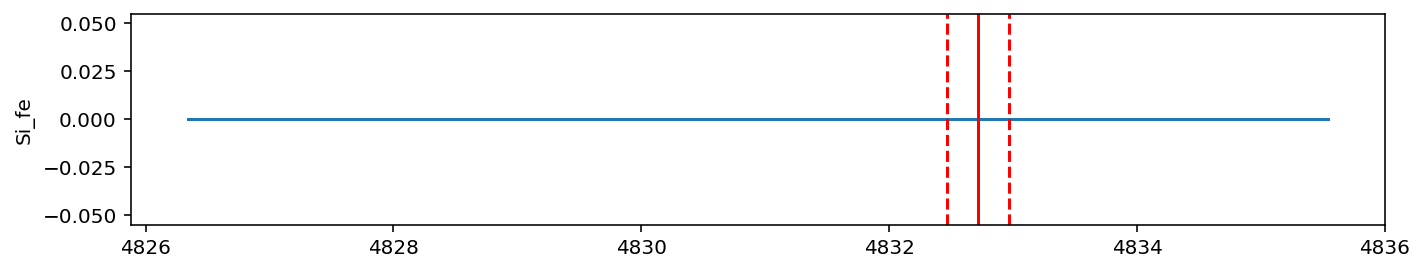

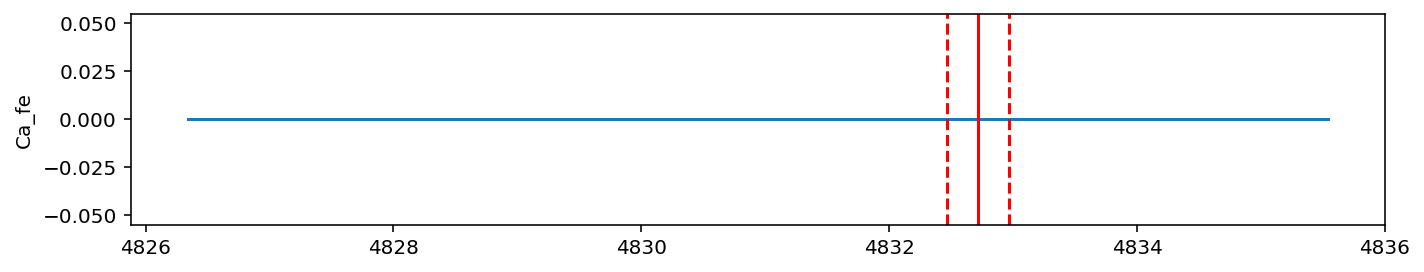

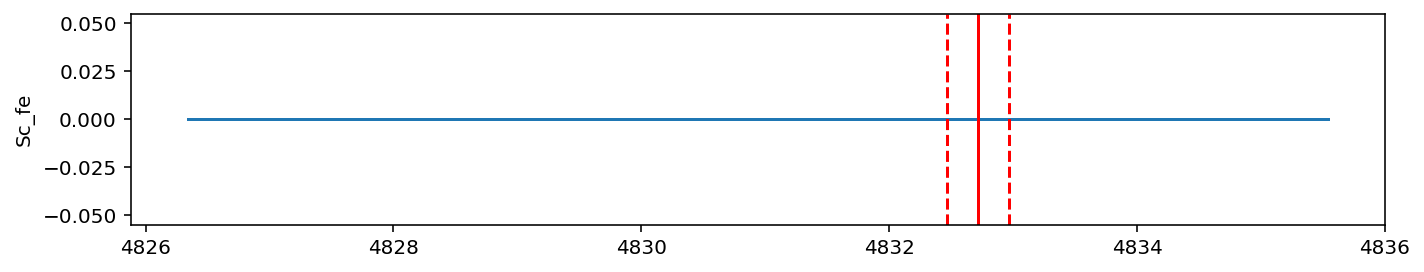

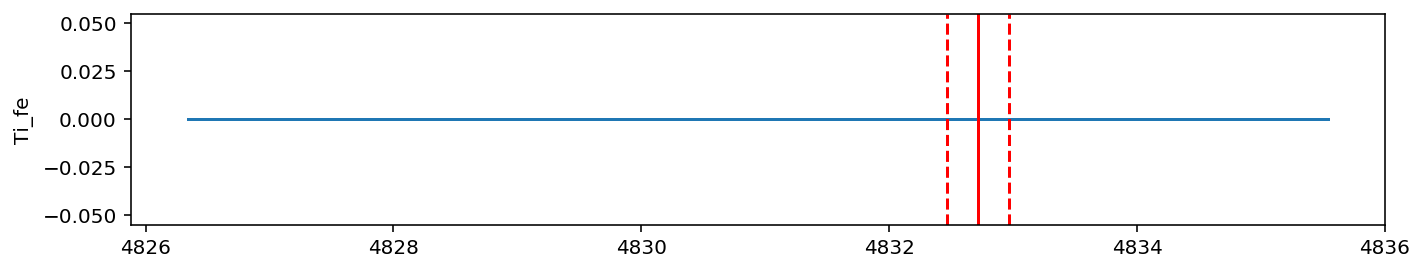

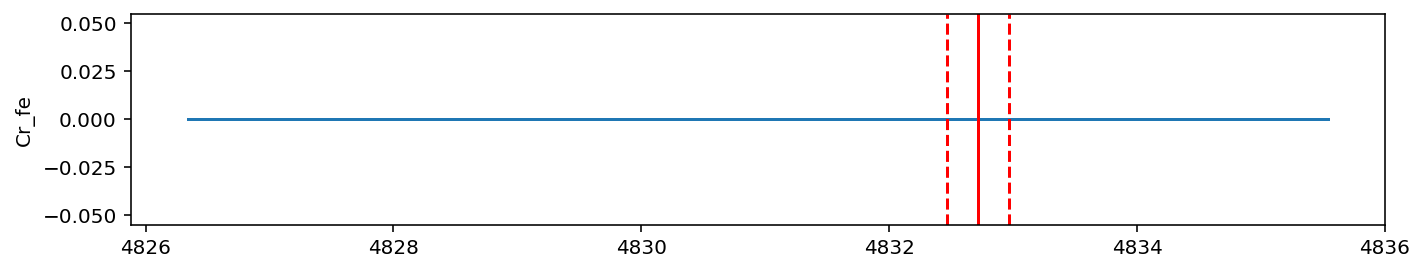

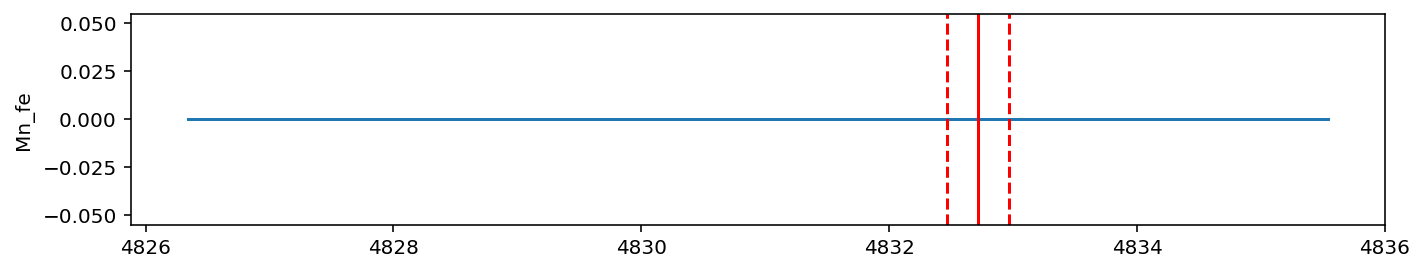

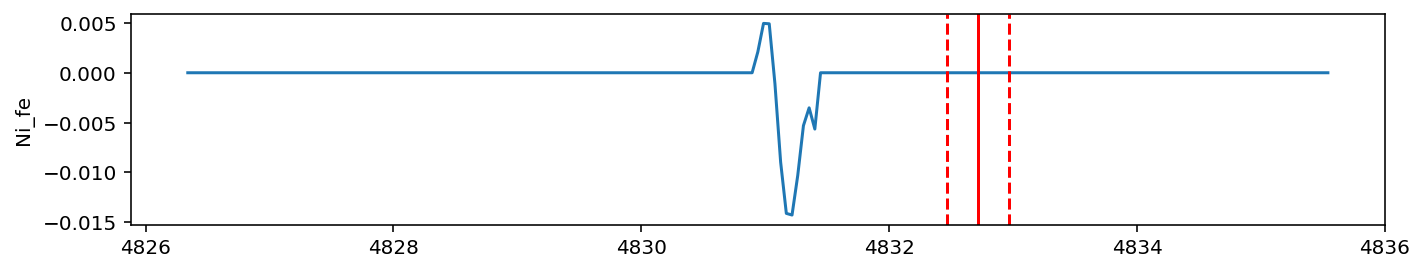

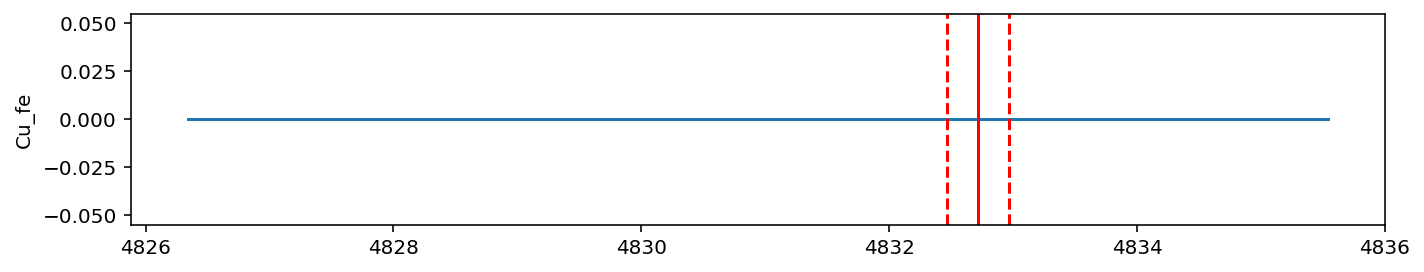

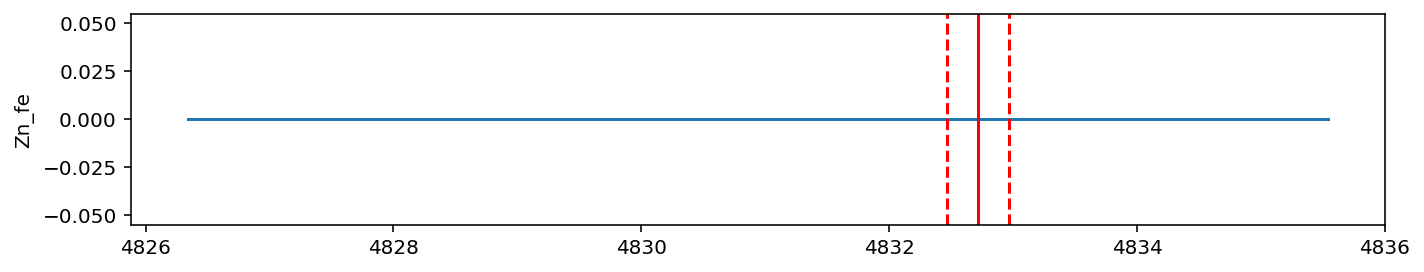

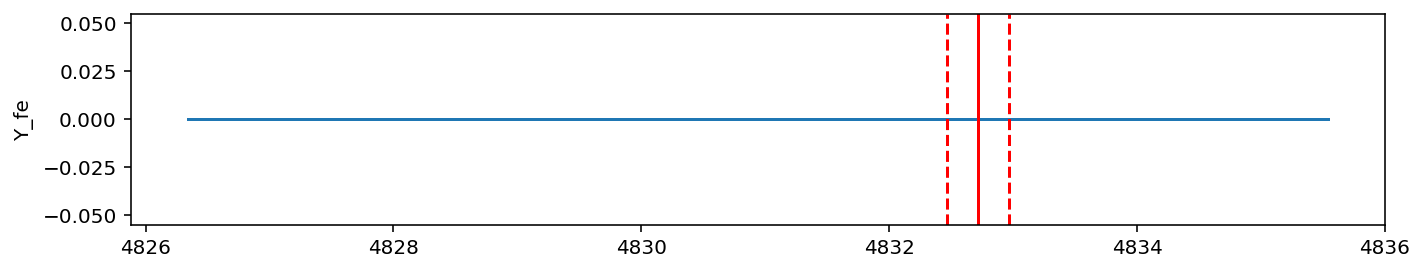

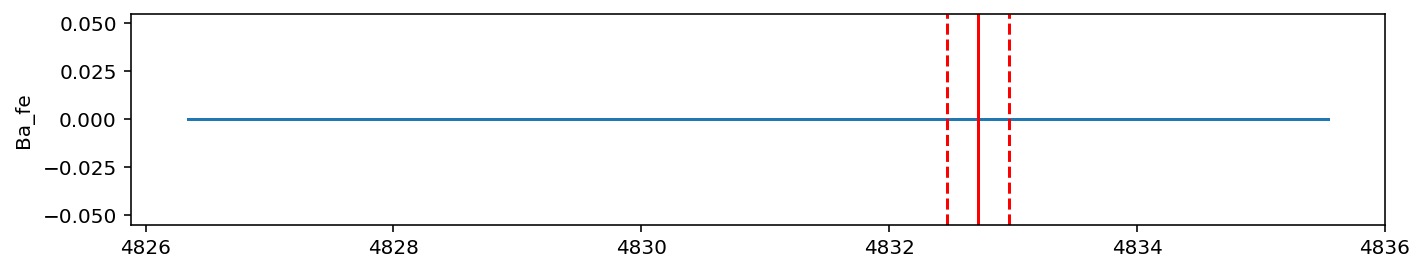

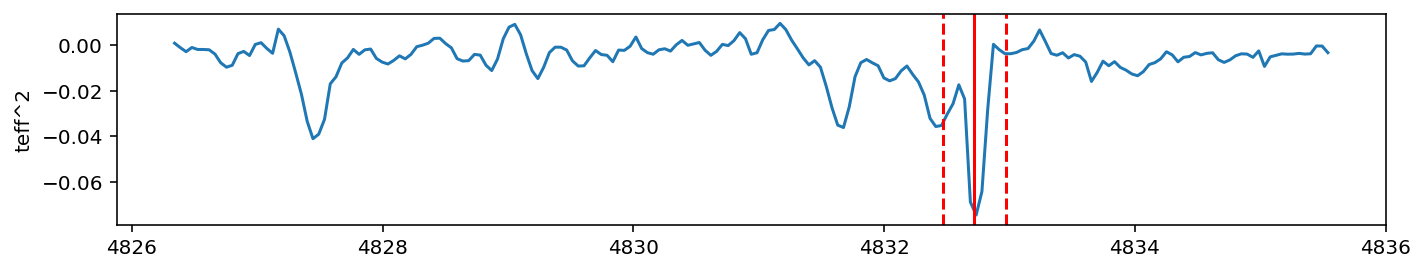

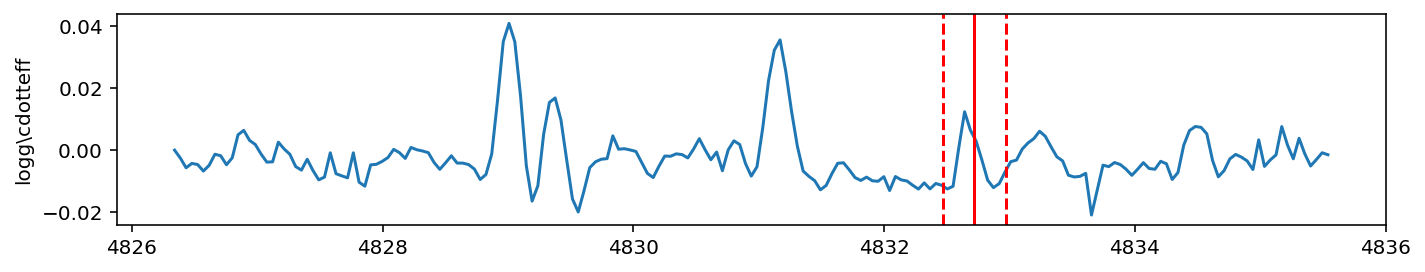

In [9]:
# This is more for myself, because I was getting interested in the pixels that have a large model scatter.
# One is clearly the Li line, but others are not as clear...

def inspect_wavelength_region(model, index, vertical_lines = [6563], wavelength=[6560,6570]):
    # let's have an option to plot the scatter with a negative index
    if index == -1:
        ylabel = 'scatter'
    else:
        ylabel = model.vectorizer.get_human_readable_label_term(index,
                label_names = model.vectorizer.label_names, mul='\cdot', pow='^')
        
    f, ax = plt.subplots(1,1,figsize=(10,2),sharey=True)
    
    in_wavelength_range = (wavelength_array >= wavelength[0]) & (wavelength_array <= wavelength[1])
    if index == -1:
        ax.plot(
            wavelength_array[in_wavelength_range],
            model.s2[in_wavelength_range]**0.5
        )
    else:
        ax.plot(
            wavelength_array[in_wavelength_range],
            model.theta[in_wavelength_range,index]
        )
    ax.set_ylabel(ylabel)
    for each_line in vertical_lines:
        ax.axvline(each_line-0.25,c='r',ls='dashed')
        ax.axvline(each_line,c='r')
        ax.axvline(each_line+0.25,c='r',ls='dashed')
    plt.tight_layout()

step_200 = 12

# Scatter remains at
# 4754.03 Mn line blend?
# 4762.35 Ti+Ni blend?
# 4763.90 not fitted
# 4768.34 not fitted
# 4772.79 core not well fitted?
# 4783.40 Mn blend?
# 4786.85 Ni blend?
# 4805.05 Ti blend?
# 4823.52 not fitted?
# 4832.72 not fitted?

lines = [4832.72]
#lines = []

for index in range(-1,20):
    inspect_wavelength_region(model, index, vertical_lines = lines, wavelength=[wavelength_array[step_200*200],wavelength_array[(step_200+1)*200]])
